# DCASE 2018 Audio Tagging Challenge

Start with importing some libraries

In [208]:
import matplotlib as plt
%matplotlib inline
import IPython.display as ipd
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.io.wavfile import read as read_wav
import librosa
from sklearn.neighbors import KNeighborsClassifier
from progressbar import ProgressBar


# Import Training Data Attributes

In [200]:
#Set notebook path
path = '/Users/humza/Documents/Kaggle/DCASE2018'
#Training data path
train_audio_path = '/Users/humza/Documents/Kaggle/DCASE2018/RawData/audio_train'
#Test data path
test_audio_path = '/Users/humza/Documents/Kaggle/DCASE2018/RawData/audio_test'

In [66]:
#Import Training data
trainAtt = pd.read_csv(path + '/train.csv')

In [174]:
#Get list of unique sorted labels
labelList=np.sort(trainAtt['label'].unique())

(41,)

In [67]:
#Show structure of the training data csv file
trainAtt.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


## Describe the training data

In [68]:
print("Number of Training Examples:", len(trainAtt))
print("Number of Manually Verified Examples", (trainAtt['manually_verified'] == 1).sum())
print("Number of Auto Labeled Examples", (trainAtt['manually_verified'] == 0).sum())

Number of Training Examples: 9473
Number of Manually Verified Examples 3710
Number of Auto Labeled Examples 5763


In [69]:
print("Number of labels", len(trainAtt.label.unique()))

Number of labels 41


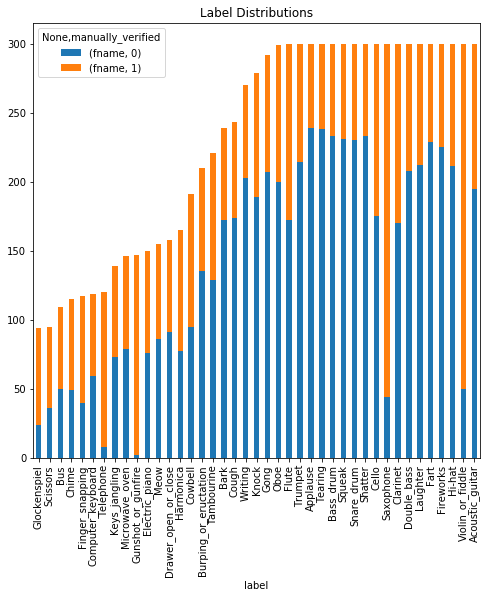

In [70]:
#Group training examples by labels
labelCategories=trainAtt.groupby(['label','manually_verified']).count()
#Sort Labels
labelCategories=labelCategories.unstack().reindex(labelCategories.unstack().sum(axis=1).sort_values().index)
#Plot
labelCategories.plot(kind="bar",stacked=True,title="Label Distributions",figsize=(8,8))

In [71]:
#Print out categories in table form
labelCategories

fname     
manually_verified         0    1
label                           
Glockenspiel             24   70
Scissors                 36   59
Bus                      50   59
Chime                    49   66
Finger_snapping          40   77
Computer_keyboard        59   60
Telephone                 8  112
Keys_jangling            73   66
Microwave_oven           79   67
Gunshot_or_gunfire        2  145
Electric_piano           76   74
Meow                     86   69
Drawer_open_or_close     91   67
Harmonica                77   88
Cowbell                  95   96
Burping_or_eructation   135   75
Tambourine              129   92
Bark                    172   67
Cough                   174   69
Writing                 203   67
Knock                   189   90
Gong                    207   85
Oboe                    200   99
Flute                   172  128
Trumpet                 214   86
Applause                239   61
Tearing                 238   62
Bass_drum               233   67
Squeak                  231   69
Snare_drum              230   70
Shatter                 233   67
Cello                   175  125
Saxophone                44  256
Clarinet                170  130
Double_bass             208   92
Laughter                212   88
Fart                    229   71
Fireworks               225   75
Hi-hat                  211   89
Violin_or_fiddle         50  250
Acoustic_guitar         195  105

Ensure we can read an audio file properly

In [72]:
audioFile = train_audio_path + '/' + trainAtt.fname[2]
print(audioFile)
ipd.Audio(audioFile)


/Users/humza/Documents/Kaggle/DCASE2018/RawData/audio_train/002d256b.wav


# Compute Audio Sampling Rates

In [96]:
#Create an empty list of audio sampling rates
samp_rate = []
#Loop through each file and calculate sampling rate
for index, fname in trainAtt.fname.iteritems():
    audioFile = train_audio_path + '/' + fname
    rate=read_wav(audioFile)[0]
    samp_rate.append(rate)
#Insert samp rate list into a new column of the trainAtt dataframe
trainAtt['samp_rate'] = samp_rate
#View updated dataframe
trainAtt.head()


,fname,label,manually_verified,samp_rate
0,00044347.wav,Hi-hat,0,44100
1,001ca53d.wav,Saxophone,1,44100
2,002d256b.wav,Trumpet,0,44100
3,0033e230.wav,Glockenspiel,1,44100
4,00353774.wav,Cello,1,44100


# Calculate MFCC Coefficients for Training Data

In [113]:
X_train = []
for index, fname in trainAtt.fname.iteritems():
    audioFile = train_audio_path + '/' + fname
    data, sr = librosa.load(audioFile)
    #Calculate mfcc coefficients for every frame of each sample
    mfcc = librosa.feature.mfcc(y=data,sr=sr,n_mfcc=13)
    #Save means of each coefficient into a training array
    X_train.append(np.mean(mfcc,axis=1))


In [117]:
np.shape(X_train)

(9473, 13)

In [114]:
#Save array to file
outfile = 'MFCCmeans.npy'
np.save(outfile,X_train)

# Fit a KNN Classifier to Training Data

In [318]:
#Fit a KNN with 20 neighbors to hopefully limit the number of times there are ties between the top 3 classes
knn = KNeighborsClassifier(n_neighbors=20)
#Fit the model
knn.fit(X_train, trainAtt.label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [319]:
#Predicitions of classification probability on Training Data
ypred_train=knn.predict_proba(X_train)

In [320]:
#View the probabilities for the classification of the first audio file in the dataframe
ypred_train[0]

array([ 0.  ,  0.05,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.05,  0.  ,  0.05,
        0.4 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.1 ,  0.  ,  0.  ,  0.05,
        0.05,  0.  ,  0.1 ,  0.05,  0.  ,  0.05,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.05,  0.  ])

In [321]:
#List the indexes of the highest class probabilities. 
(-ypred[0]).argsort()[:3]

array([18, 29, 23])

In [322]:
#Match to actual labels
labelList[(-ypred[0]).argsort()[:3]]

array(['Flute', 'Oboe', 'Hi-hat'], dtype=object)

# Calculate MFCC Coefficient Means for Test Data

In [198]:
#Import Test data filenames from csv
testfNames = pd.read_csv(path + '/sample_submission.csv')
#View structure of imported dataframe
display(testfNames.head())
#View number of test samples
print("Number of Test Samples:",len(testfNames.fname))

,fname,label
0,00063640.wav,Laughter Hi-Hat Flute
1,0013a1db.wav,Laughter Hi-Hat Flute
2,002bb878.wav,Laughter Hi-Hat Flute
3,002d392d.wav,Laughter Hi-Hat Flute
4,00326aa9.wav,Laughter Hi-Hat Flute


Number of Test Samples: 9400


In [ ]:
SAMPLE_RATE = 44100
#returns mfcc features with mean and standard deviation along time
def get_mfcc(name, path):
    b, _ = librosa.core.load(path + name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        gmm = librosa.feature.mfcc(b, sr = SAMPLE_RATE, n_mfcc=13)
        return pd.Series(np.hstack((np.mean(gmm, axis=1), np.std(gmm, axis=1))))
    except:
        print('bad file')
        return pd.Series([0]*40)

In [256]:
X_test = []
SAMPLE_RATE = 44100
pbar = ProgressBar()
for index in pbar(range(0,len(testfNames.fname))):
    audioFile = test_audio_path + '/' + testfNames.fname[index]
    data = librosa.load(audioFile)[0]
    try:
        #Calculate mfcc coefficients for every frame of each sample
        mfcc = librosa.feature.mfcc(y=data,sr=SAMPLE_RATE,n_mfcc=13)
        #Save means of each coefficient into a training array
        X_test.append(np.mean(mfcc,axis=1))
    except:
        X_test.append(9999)
        print('bad file', index)
        

  3% (338 of 9400) |                       | Elapsed Time: 0:03:00 ETA: 2:42:33

bad file 388


 37% (3484 of 9400) |########              | Elapsed Time: 0:23:15 ETA: 6:16:30

bad file 4009


 61% (5795 of 9400) |#############         | Elapsed Time: 0:34:05 ETA: 0:34:07

bad file 6603


100% (9400 of 9400) |#####################| Elapsed Time: 0:44:46 Time: 0:44:46


In [297]:
#Save array to file
outfile = 'MFCCmeansTest.npy'
np.save(outfile,X_test)

In [266]:
#BAD FILE INDEXES: 388, 4009, 6603

audioFile = test_audio_path + '/' + testfNames.fname[388]
print(audioFile)
ipd.Audio(audioFile)


/Users/humza/Documents/Kaggle/DCASE2018/RawData/audio_test/0b0427e2.wav


In [295]:
np.shape(X_test)

(9400, 13)

# Predict Test Labels

In [381]:
#Predicitions of classification probability on Training Data
ypred_test=knn.predict_proba(X_test)
test_labels = []

for index in range(0,len(testfNames.fname)):
    #Match to actual labels
    test_labels.append(labelList[(-ypred_test[index]).argsort()[:3]])

# Submission Output

In [395]:
subcsv = pd.DataFrame()
subcsv['fname'] = testfNames.fname
subcsv['label'] = np.empty(len(testfNames.fname))

In [398]:
subcsv.head()

,fname,label
0,00063640.wav,Tambourine Finger_snapping Scissors
1,0013a1db.wav,Finger_snapping Violin_or_fiddle Shatter
2,002bb878.wav,Bus Acoustic_guitar Bass_drum
3,002d392d.wav,Gong Knock Electric_piano
4,00326aa9.wav,Oboe Clarinet Flute


In [396]:
for index in range(0,9400):
    subcsv['label'][index] = ' '.join(map(str, test_labels[index]))

/Users/humza/anaconda2/envs/dcase2018/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/humza/anaconda2/envs/dcase2018/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [399]:
#Save CSV
subcsv.to_csv('submission.csv', index=False)